<a href="https://colab.research.google.com/github/anuragb1090/JH_Agriculture/blob/master/100_FeatureEngineering_JH_Agriculture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [232]:
# %%time

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [234]:
train = pd.read_csv('/content/001_train.csv')
test = pd.read_csv('/content/001_test.csv')

# sample_submission = pd.read_csv('/content/sample_submission_V9Inaty.csv.csv')
print('Train shape:{}'.format(train.shape))
print('Test shape:{}'.format(test.shape))

Train shape:(88858, 10)
Test shape:(59310, 9)


In [235]:
train['source'] = 'train'
test['source'] = 'test'

unified = pd.concat([train, test], axis=0)
unified.shape

(148168, 11)

In [236]:
unified.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,source
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,train
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,train
2,F00000004,257,1,0,1,0,0.0,0,2,1.0,train
3,F00000005,257,1,1,1,0,0.0,0,2,1.0,train
4,F00000006,342,1,0,1,0,0.0,0,2,1.0,train


## Ratio of variables to determine per unit metrics

In [237]:
unified['usage_insects'] = unified['Estimated_Insects_Count']/unified['Number_Weeks_Used']
unified.loc[unified['usage_insects'].isin([np.nan, np.inf, -np.inf]), 'usage_insects'] = 0

In [238]:
unified['wks_used_to_quit'] = unified['Number_Weeks_Used']/unified['Number_Weeks_Quit']
unified.loc[unified['wks_used_to_quit'].isin([np.nan, np.inf, -np.inf]), 'wks_used_to_quit'] = 0

In [239]:
unified.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,source,usage_insects,wks_used_to_quit
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,train,0.0,0.0
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,train,0.0,0.0
2,F00000004,257,1,0,1,0,0.0,0,2,1.0,train,0.0,0.0
3,F00000005,257,1,1,1,0,0.0,0,2,1.0,train,0.0,0.0
4,F00000006,342,1,0,1,0,0.0,0,2,1.0,train,0.0,0.0


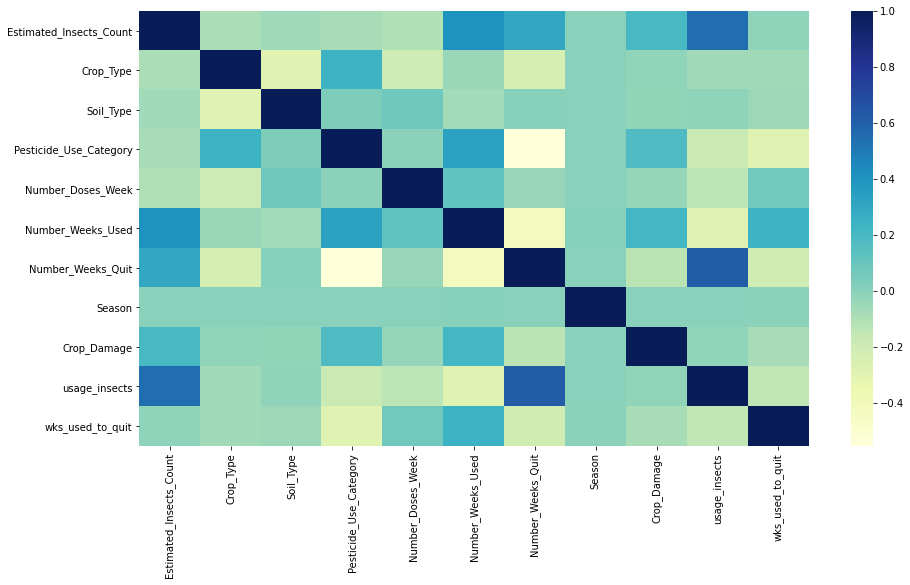

In [240]:
fig, ax = plt.subplots(figsize=(15,8))

tmp = unified[unified['source']=='train']
cr = tmp.corr()
sns.heatmap(cr, cmap='YlGnBu')

## Compute stats of continuous variables based on categorical variables

In [241]:
def multiple_aggregations(df, cat_vars, con_vars, suffix):
  tmp = df.groupby([cat_vars]).agg({con_vars:[np.mean, np.std, min, max]}).\
                                    reset_index()
  tmp.columns = ['_'.join(col).strip() for col in tmp.columns.values]
  tmp.columns = [str(c) + '_' + str(suffix) for c in tmp.columns]
  tmp.columns.values[0] = cat_vars
  
  df = pd.merge(df, tmp, on=[cat_vars], how='left')
  return df

In [242]:
train = unified[unified['source']=='train']
test = unified[unified['source']=='test']

con_var = ['Estimated_Insects_Count', 'Number_Doses_Week',
           'Number_Weeks_Used', 'Number_Weeks_Quit']


for con in con_var:
  train = multiple_aggregations(train, 'Crop_Type', con, 'crop')
  train = multiple_aggregations(train, 'Soil_Type', con, 'soil')
  train = multiple_aggregations(train, 'Pesticide_Use_Category', con, 'pest')
  train = multiple_aggregations(train, 'Season', con, 'ssn')

  test = multiple_aggregations(test, 'Crop_Type', con, 'crop')
  test = multiple_aggregations(test, 'Soil_Type', con, 'soil')
  test = multiple_aggregations(test, 'Pesticide_Use_Category', con, 'pest')
  test = multiple_aggregations(test, 'Season', con, 'ssn')


train.drop(['source'], axis=1, inplace=True)
test.drop(['source'], axis=1, inplace=True)

In [243]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,usage_insects,wks_used_to_quit,Estimated_Insects_Count_mean_crop,Estimated_Insects_Count_std_crop,Estimated_Insects_Count_min_crop,Estimated_Insects_Count_max_crop,Estimated_Insects_Count_mean_soil,Estimated_Insects_Count_std_soil,Estimated_Insects_Count_min_soil,Estimated_Insects_Count_max_soil,Estimated_Insects_Count_mean_pest,Estimated_Insects_Count_std_pest,Estimated_Insects_Count_min_pest,Estimated_Insects_Count_max_pest,Estimated_Insects_Count_mean_ssn,Estimated_Insects_Count_std_ssn,Estimated_Insects_Count_min_ssn,Estimated_Insects_Count_max_ssn,Number_Doses_Week_mean_crop,Number_Doses_Week_std_crop,Number_Doses_Week_min_crop,Number_Doses_Week_max_crop,Number_Doses_Week_mean_soil,Number_Doses_Week_std_soil,Number_Doses_Week_min_soil,Number_Doses_Week_max_soil,Number_Doses_Week_mean_pest,Number_Doses_Week_std_pest,Number_Doses_Week_min_pest,Number_Doses_Week_max_pest,Number_Doses_Week_mean_ssn,Number_Doses_Week_std_ssn,Number_Doses_Week_min_ssn,Number_Doses_Week_max_ssn,Number_Weeks_Used_mean_crop,Number_Weeks_Used_std_crop,Number_Weeks_Used_min_crop,Number_Weeks_Used_max_crop,Number_Weeks_Used_mean_soil,Number_Weeks_Used_std_soil,Number_Weeks_Used_min_soil,Number_Weeks_Used_max_soil,Number_Weeks_Used_mean_pest,Number_Weeks_Used_std_pest,Number_Weeks_Used_min_pest,Number_Weeks_Used_max_pest,Number_Weeks_Used_mean_ssn,Number_Weeks_Used_std_ssn,Number_Weeks_Used_min_ssn,Number_Weeks_Used_max_ssn,Number_Weeks_Quit_mean_crop,Number_Weeks_Quit_std_crop,Number_Weeks_Quit_min_crop,Number_Weeks_Quit_max_crop,Number_Weeks_Quit_mean_soil,Number_Weeks_Quit_std_soil,Number_Weeks_Quit_min_soil,Number_Weeks_Quit_max_soil,Number_Weeks_Quit_mean_pest,Number_Weeks_Quit_std_pest,Number_Weeks_Quit_min_pest,Number_Weeks_Quit_max_pest,Number_Weeks_Quit_mean_ssn,Number_Weeks_Quit_std_ssn,Number_Weeks_Quit_min_ssn,Number_Weeks_Quit_max_ssn
0,F00000001,188,1,0,1,0,0.0,0,1,0.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1394.991673,853.620148,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0.0,0,0,25.881719,15.610313,0,95,27.782579,12.131219,0.0,67.0,29.308552,11.929009,0.0,67.0,0.0,0.0,0.0,0.0,28.489250,11.80114,0.0,67.0,5.924374,8.321529,0,50,9.504696,9.773190,0,50,0.0,0.0,0,0,9.600810,9.926603,0,50
1,F00000003,209,1,0,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0.0,0,0,25.842004,15.594075,0,95,27.782579,12.131219,0.0,67.0,29.308552,11.929009,0.0,67.0,0.0,0.0,0.0,0.0,28.638378,11.81034,0.0,67.0,5.924374,8.321529,0,50,9.504696,9.773190,0,50,0.0,0.0,0,0,9.568514,9.860688,0,50
2,F00000004,257,1,0,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0.0,0,0,25.842004,15.594075,0,95,27.782579,12.131219,0.0,67.0,29.308552,11.929009,0.0,67.0,0.0,0.0,0.0,0.0,28.638378,11.81034,0.0,67.0,5.924374,8.321529,0,50,9.504696,9.773190,0,50,0.0,0.0,0,0,9.568514,9.860688,0,50
3,F00000005,257,1,1,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1346.986203,831.661814,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,27.193131,15.984844,0,95,0.0,0.0,0,0,25.842004,15.594075,0,95,27.782579,12.131219,0.0,67.0,27.739438,11.556327,0.0,67.0,0.0,0.0,0.0,0.0,28.638378,11.81034,0.0,67.0,5.924374,8.321529,0,50,9.690750,10.048298,0,50,0.0,0.0,0,0,9.568514,9.860688,0,50
4,F00000006,342,1,0,1,0,0.0,0,2,1.0,0.0,0.0,1279.369148,831.725509,150,4097,1443.049019,861.047816,150,4097,1650.673835,1105.694378,150,4097,1401.148224,848.404542,150,4097,21.108473,13.534049,0,95,24.713033,15.087583,0,95,0.0,0

In [244]:
train.shape

(88858, 76)

In [245]:
train.to_csv('100_train.csv', index=False)
test.to_csv('100_test.csv', index=False)